# E2IDS

In [24]:
from sklearnex import patch_sklearn
patch_sklearn()
import time
# import numpy for data cleaning and perparation
import pandas as pd
import numpy as np
from sklearn.metrics import (roc_curve, auc, roc_auc_score, confusion_matrix)
import itertools
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,precision_recall_fscore_support,accuracy_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ITMO_FS.filters.univariate import gini_index
#pd.options.display.float_format = "{:,.3f}".format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [25]:
# Data exploration and preprocessing
# About the dataset :
# The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the 
# Cyber Range Lab of UNSW Canberra for generating a hybrid of real modern normal activities and synthetic contemporary attack 
# behaviours.

In [26]:
# Importing the dataset 
data = pd.read_csv('UNSW_NB15/UNSW-NB15.csv',low_memory=False)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 42 columns):
 #   Column            Dtype  
---  ------            -----  
 0   proto             object 
 1   state             object 
 2   dur               float64
 3   sbytes            int64  
 4   dbytes            int64  
 5   sttl              int64  
 6   dttl              int64  
 7   sloss             int64  
 8   dloss             int64  
 9   service           object 
 10  Sload             float64
 11  Dload             float64
 12  Spkts             int64  
 13  Dpkts             int64  
 14  swin              int64  
 15  dwin              int64  
 16  stcpb             int64  
 17  dtcpb             int64  
 18  smeansz           int64  
 19  dmeansz           int64  
 20  trans_depth       int64  
 21  res_bdy_len       int64  
 22  Sjit              float64
 23  Djit              float64
 24  Sintpkt           float64
 25  Dintpkt           float64
 26  tcprtt        

In [30]:
# Making a copy of the data to keep it save
data_copy = data

In [31]:

threshold = 0
def chekMissingVal(dataSet):
    colsIsEmpty = dataSet.isnull().sum()
    colsIsEmpty = colsIsEmpty.to_frame(name="Features & Missing Values")
    print(colsIsEmpty)

# Function to drop unnecessary attributes

def dropCols(dataSet,cols):
    dataSet.drop(cols,axis='columns',inplace=True)


# A function to check the balance of the data

def isBalanced(target,dataSet,X):
    counter = Counter(target)
    print("The dataset contains {} records of class Normal which means {} %".format(counter[0],np.round((counter[0]/(counter[0] + counter[1]))*100,2)))
    print("The dataset contains {} records of class Attack which means {} %".format(counter[1],np.round((counter[1]/(counter[0]+counter[1]))*100,2)))
    print(f"The old dataset size  {data.shape[0]:,} and The resampled dataset size is {X.shape[0]:,}")
    plt.barh(['Normal','Attack'],[counter[0],counter[1]],color=[(0.02, 0.60, 0.38),(0.91, 0.12, 0.39)])

# A function to display the model performance with diffrent metrics
def model_report(y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report
    df_classification_report['precision'] = round(df_classification_report['precision'],3)*100
    df_classification_report['recall'] = round(df_classification_report['recall'],3)*100
    df_classification_report['f1-score'] = round(df_classification_report['f1-score'],3)*100
    df_classification_report['support'] = round(df_classification_report['support'],0)
    #print(df_classification_report['precision']['accuracy'])
    
    return df_classification_report
# Gather feature importance

def getImportance(features_names,importance):
    importances = pd.DataFrame({'feature':features_names,'importance':np.round(importance,3)})
    importances = importances.sort_values('importance',ascending=False)
    return importances


def pltImportances(importance):
    plt.xlabel("Gini Score")
    plt.ylabel("Security Features")
    plt.title("Features Gini Scores")
    plt.barh(importances['feature'],importances['importance'])
    
def giniScore(X,Y):
    Y_ = np.array(Y)
    importance = gini_index(X, Y_)
    return importance

def selectFeatures(X,importances,threshold):
    X_selected = X
    c = X.columns
    i=0
    count_sel_f=0
    toBeDroped = []
    Feautre  =  []
    Ranking   = []
    for cs in c:
    
        if  importances['importance'][i]<=threshold:
            count_sel_f=count_sel_f+1
            Feautre.append(cs)
            Ranking.append(importances['importance'][i])
        else:
            toBeDroped.append(cs)
        i=i+1
    X_selected = X.drop(toBeDroped,axis='columns')
    print("the Number of selected features is : ",count_sel_f)
    return [X_selected,Feautre,Ranking]
    #X = X.drop(toBeDroped,axis='columns',inplace=True)

def plotTreeGraph(DT_clf,X):
    graph = Source(export_graphviz(DT_clf, out_file=None, feature_names=X.columns))
    graph.format = 'png'
    graph.render('dt', view=True);



def plot_roc_curve(y_test, y_test_score):
 
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()


def show_cm(y_true, y_pred, class_names=None, model_name=None):
 
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    if model_name:
        plt.title('Confusion Matrix: {}'.format(model_name))
    else:
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    if class_names:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    else:
        class_names = set(y_true)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    thresh = cf.max() / 2.0
    for i, j in itertools.product(range(cf.shape[0]),
                               range(cf.shape[1])):
        plt.text(j, i, cf[i, j],
            horizontalalignment='center',
            color='white' if cf[i, j] > thresh else 'black',
            )
    plt.colorbar()

In [32]:
# Saving target classes
target = data_copy['label']

In [33]:
# Drop unnecessary attributes
#cols to drop
cols = ['label']
dropCols(data_copy,cols)

The dataset contains 2218764 records of class Normal which means 87.35 %
The dataset contains 321283 records of class Attack which means 12.65 %
The old dataset size  2,540,047 and The resampled dataset size is 2,540,047


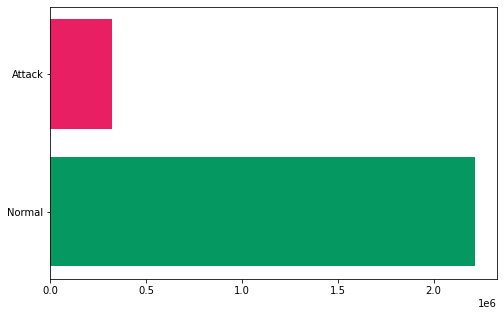

In [34]:
# Is our data Balanced ?
isBalanced(target,data_copy,X=data_copy)

In [35]:
X,Y = data_copy,target

The dataset contains 535471 records of class Normal which means 62.5 %
The dataset contains 321283 records of class Attack which means 37.5 %
The old dataset size  2,540,047 and The resampled dataset size is 856,754


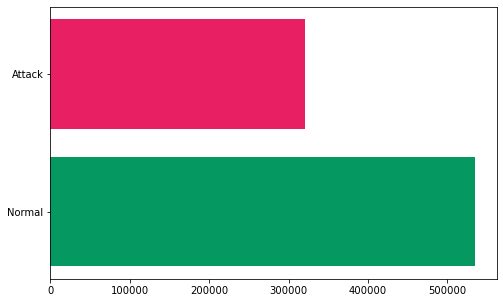

In [36]:
# define oversampling strategy
RUS = RandomUnderSampler(sampling_strategy=0.6)
X,Y = RUS.fit_resample(data_copy, target)
isBalanced(Y,X,X)

In [37]:
# The dataset contain three nominal variabls [proto,service,state]
proto   = LabelEncoder()
service = LabelEncoder()
state   = LabelEncoder()

X['proto'] = proto.fit_transform(X['proto'])
X['service']=service.fit_transform(X['service'])
X['state']=state.fit_transform(X['state'])


In [38]:
# Calacuting Gini impurity for all features using ITMO_FS Library
from ITMO_FS.filters.univariate import gini_index
x=X.to_numpy()
y=Y.to_numpy()
importances=getImportance(X.columns,gini_index(x, y))
importances_=importances
importances

,feature,importance
29,is_sm_ips_ports,1.000
11,Dload,0.998
4,dbytes,0.947
8,dloss,0.945
19,dmeansz,0.943
13,Dpkts,0.942
21,res_bdy_len,0.900
12,Spkts,0.882
24,Sintpkt,0.877
14,swin,0.876


In [39]:
# Selection Top featues based on the threshold 0.33
threshold = 0.33
X_selected = selectFeatures(X,importances_,threshold)
X_selected[0].info()

the Number of selected features is :  11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856754 entries, 0 to 856753
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sttl              856754 non-null  int64  
 1   Sload             856754 non-null  float64
 2   tcprtt            856754 non-null  float64
 3   synack            856754 non-null  float64
 4   ackdat            856754 non-null  float64
 5   ct_state_ttl      856754 non-null  int64  
 6   ct_srv_dst        856754 non-null  int64  
 7   ct_dst_ltm        856754 non-null  int64  
 8   ct_src_dport_ltm  856754 non-null  int64  
 9   ct_dst_sport_ltm  856754 non-null  int64  
 10  ct_dst_src_ltm    856754 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 71.9 MB


In [40]:
X_selected_=X_selected[0]

In [41]:
X_selected_ = StandardScaler().fit_transform(X_selected_)
X_train, X_test, Y_train, Y_test = train_test_split(X_selected_, Y,test_size = 0.3)

In [42]:
importances=getImportance(X_selected[0].columns,X_selected[2])

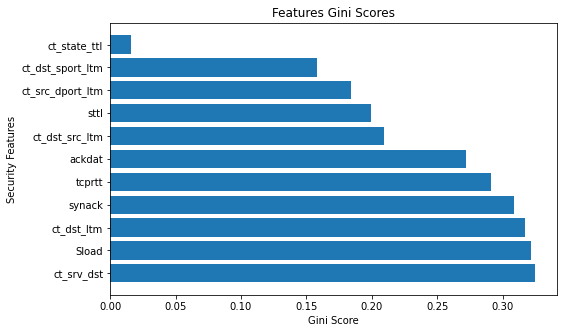

In [43]:
plt.rcParams['figure.figsize'] = [8, 5]
pltImportances(importances)

The dataset contains 375048 records of class Normal which means 54.05 %
The dataset contains 318790 records of class Attack which means 45.95 %
The old dataset size  2,540,047 and The resampled dataset size is 693,838


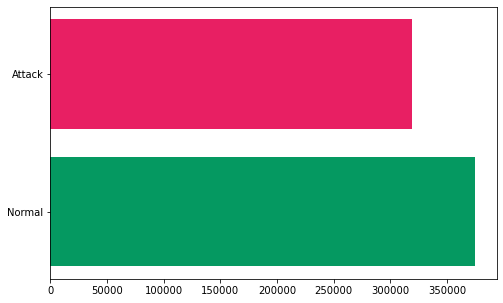

In [44]:
#define oversampling strategy (Only For the Training Set)
RUS = RandomOverSampler(sampling_strategy=0.85)
X_train,Y_train = RUS.fit_resample(X_train,Y_train)

#Is our data Balanced ?
isBalanced(Y_train,X_train,X_train)

In [45]:
# fit the model with data
DT_clf_enhanced = DecisionTreeClassifier().fit(X_train,Y_train)
#fit the model with the testing data
prd = DT_clf_enhanced.predict(X_test)


# Generating the model report
report = model_report(prd,Y_test)
acc= round(accuracy_score(Y_test, prd),3)*100
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",acc)
report

Accuracy: 98.7


,precision,recall,f1-score,support
0,99.0,99.0,99.0,160526.0
1,98.3,98.4,98.3,96501.0
accuracy,98.7,98.7,98.7,1.0
macro avg,98.6,98.7,98.6,257027.0
weighted avg,98.7,98.7,98.7,257027.0


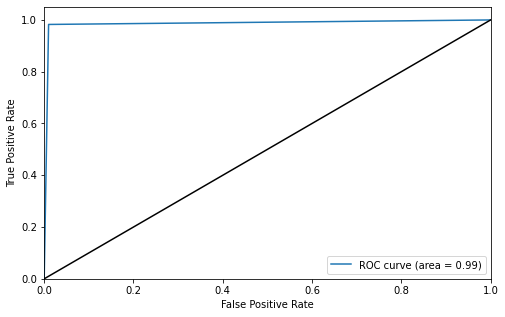

In [46]:
#plotTreeGraph(DT_clf_enhanced,X_selected)
plot_roc_curve(Y_test, prd)

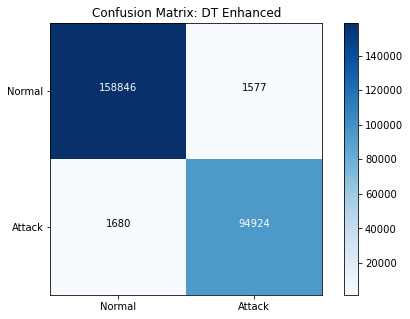

In [47]:
show_cm(Y_test, prd, class_names=["Normal","Attack"], model_name='DT Enhanced')